In [84]:
import numpy as np
import requests
import networkx as nx
import matplotlib.pyplot as plt
import node2vec
from tqdm import tqdm
from gensim.models import Word2Vec

## Algorithms

In [87]:
# Algorithm 1
def CN_VEC(X, A, S, k):
    """
    X: array, Covariates of all nodes. For nodes which covariates are unknown array contains NaN
    A: array, Adjacency matrix of the graph (now weighted)
    S: array of indexes, Set of nodes with known covariates
    k: number of neighbors
    
    """
    all_nodes = set(np.arange(len(A)))
    no_cov_nodes = all_nodes - set(S)
    X_hat = X.copy()
    
    for node_i in no_cov_nodes:
        dists = []
        for node_j in tqdm(S):
            C_i = np.delete(A[node_i] @ A, [node_i, node_j])
            C_j = np.delete(A[node_j] @ A, [node_i, node_j])
            dist = np.sum((C_i**2 - 2) * (C_i >= 2) + (C_j**2 - 2) * (C_j >= 2) - 2 * C_i * C_j)
            dists.append(dist)
        idxs = np.argsort(dists)[:k]
        ktop = np.array(S)[idxs]
        X_hat[node_i] = np.mean(X[ktop])
        
    return X_hat

In [34]:
# Algorithm 2
def SVD_RBF(X, A, S, theta, d):
    """
    X: array, Covariates of all nodes. For nodes which covariates are unknown array contains NaN
    A: array, Adjacency matrix of the graph (now weighted)
    S: array of indexes, Set of nodes with known covariates
    theta: bandwidth
    d: rank of matrix
    
    """
    
    U, E, Vh = np.linalg.svd(A, hermitian=True)
    U = U[:, :d]
    E = E[:d]
    V = U * E**(1/2)
    
    all_nodes = set(np.arange(len(A)))
    no_cov_nodes = all_nodes - set(S)
    X_hat = X.copy()
    
    for node_i in no_cov_nodes:
        x_hat_num = 0
        x_hat_denom = 0
        for node_j in S:
            x_hat_num += np.exp(-np.linalg.norm(V[node_i] - V[node_j])**2 / 2 / theta**2) * X[node_j]
            x_hat_denom += np.exp(-np.linalg.norm(V[node_i] - V[node_j])**2 / 2 / theta**2)
        X_hat[node_i] = x_hat_num / x_hat_denom
        
    return X_hat

In [35]:
def NBR(X, A, S):
    all_nodes = set(np.arange(len(A)))
    no_cov_nodes = all_nodes - set(S)
    X_hat = X.copy()
    
    for node_i in no_cov_nodes:
        neighbors = np.array(list(set(np.array(list(all_nodes))[A[node_i]]) - no_cov_nodes))
        X_hat[node_i] = np.mean(X[neighbors])
        
    return X_hat

In [36]:
def W_PPR(X, A, S, k):
    all_nodes = set(np.arange(len(A)))
    no_cov_nodes = all_nodes - set(S)
    X_hat = X.copy()
    
    gamma = np.exp(-.25)
    D = np.diag(A @ np.ones(A.shape[0]))
    M = (1 - gamma) * np.linalg.inv(np.eye(D.shape[0]) - gamma * A @ np.linalg.inv(D))
    W = (M + M.T) / 2
    
    for node_i in no_cov_nodes:
        neighbors = np.argsort(W[node_i])[np.isin(np.argsort(W[node_i]), S)][-k:]
        X_hat[node_i] = np.mean(X[neighbors])
        
    return X_hat

In [37]:
def Jaccard(X, A, S, k):
    all_nodes = set(np.arange(len(A)))
    no_cov_nodes = all_nodes - set(S)
    X_hat = X.copy()
    
    C = A @ A
    d = A @ np.ones(A.shape[0]).reshape(-1,1) @ np.ones(A.shape[0]).reshape(1,-1)
    W = C / (d + d.T - C)
    
    for node_i in no_cov_nodes:
        neighbors = np.argsort(W[node_i])[np.isin(np.argsort(W[node_i]), S)][-k:]
        X_hat[node_i] = np.mean(X[neighbors])
        
    return X_hat

In [38]:
def CN(X, A, S, k):
    all_nodes = set(np.arange(len(A)))
    no_cov_nodes = all_nodes - set(S)
    X_hat = X.copy()
    
    W = A @ A
    
    for node_i in no_cov_nodes:
        neighbors = np.argsort(W[node_i])[np.isin(np.argsort(W[node_i]), S)][-k:]
        X_hat[node_i] = np.mean(X[neighbors])
        
    return X_hat

In [39]:
# https://github.com/aditya-grover/node2vec
def learn_embeddings(walks):
    '''
    Learn embeddings by optimizing the Skipgram objective using SGD.
    '''
    walks = [list(map(str, walk)) for walk in walks]
    model = Word2Vec(walks, vector_size=128, window=10, min_count=0, sg=1, workers=8, epochs=1)
    
    return model

def main(A):
    '''
    Pipeline for representational learning for all nodes in a graph.
    '''
    nx_G = nx.from_numpy_array(A)
    G = node2vec.Graph(nx_G, False, 1, 1)
    G.preprocess_transition_probs()
    walks = G.simulate_walks(10, 80)
    
    return learn_embeddings(walks)
    
def Node2Vec(X, A, S, theta, k):
    all_nodes = set(np.arange(len(A)))
    no_cov_nodes = all_nodes - set(S)
    X_hat = X.copy()
    
    embeddings = main(A)
    
    for node_i in no_cov_nodes:
        sims = []
        for node_j in S:
            sims.append(np.exp(-np.linalg.norm(embeddings.wv[node_i] - embeddings.wv[node_j])**2 / 2 / theta**2))
        idxs = np.argsort(sims)[-k:]
        ktop = np.array(S)[idxs]
        X_hat[node_i] = np.mean(X[ktop])
                        
    return X_hat

In [70]:
def graph_to_d_atleast2(G):
    """
    This function is used to transform the original graph to a graph with minimum degree at least 2
    """
    N = len(G.nodes)
    new_node = N+1
    source_list = []
    target_list = []
    for i in range(1,N+1):
        if G.degree[i] == 1:
            neigh = list(G.neighbors(i))
            source_list = [source_list, i, new_node]
            target_list = [target_list, new_node, neigh[0]]
            new_node = new_node + 1

    G = G.add_edges_from(list(zip(source_list,target_list)))
    
    return G

def graph2lazy_nb_line_graph(G,mode):
    """
    graph2lazy_nb_line_graph is used for transforming an undirected graph to a lazy non-backtracking line graph
    which has a 2m by 2m symmetric adjacency matrix. This line graph is constructed by a symmetrication process
    that denotes a average sum of non-backtracking transtion matrix and its transpose.
    Input:
       Data  - The adjacency matrix of original graph
       N     - The node number of original graph
       M     - The edge number of original graph
    Output:
      Oriented Line Graph with a sparse 2M *2M matrix
    """


def NOBE(G, d=10):

    N = len(G.nodes)

    LG = graph_to_d_atleast2(G)
    LLG = graph2nb_line_graph(LG, 1)
    
#     [U,D] = eigs_nodes(LLG,K+1,mode)
#     [D,idx] = sort(diag(D),'descend')
#     U = U(1:N, idx(2:K+1))

### Tests

#### Artificial

In [40]:
A = np.array([[0,1,1,0],[1,0,1,1],[1,1,0,1],[0,1,1,0]])

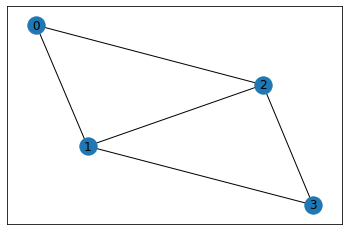

In [41]:
G = nx.from_numpy_array(A)
nx.draw_networkx(G)

In [42]:
X = np.array([np.nan,3,1,np.nan])

In [50]:
CN_VEC(X, A, [1,2], 2)

array([2., 3., 1., 2.])

In [51]:
SVD_RBF(X, A, [1,2], 1.5, 2)

array([2., 3., 1., 2.])

In [52]:
NBR(X, A, [1,2])

array([3., 3., 1., 3.])

In [53]:
W_PPR(X, A, [1,2], 2)

array([2., 3., 1., 2.])

In [54]:
Jaccard(X, A, [1,2], 2)

array([2., 3., 1., 2.])

In [55]:
CN(X, A, [1,2], 2)

array([2., 3., 1., 2.])

In [56]:
Node2Vec(X, A, [1,2], 1.5, 2)

Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


array([2., 3., 1., 2.])

#### Real

In [168]:
url = 'https://raw.githubusercontent.com/network-science-course/network-science-course/main/datasets/the_matrix_graph.gexf'
open('the_matrix_graph.gexf', 'wb').write(requests.get(url).content);

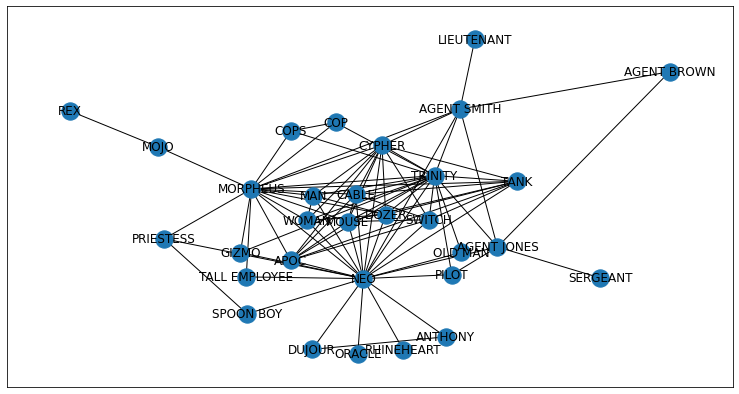

In [169]:
def get_matrix_graph():
    G = nx.read_gexf('the_matrix_graph.gexf')
    mapping = {}
    for node in G.nodes:
        mapping[node] = G.nodes[node]['label']
    G = nx.relabel_nodes(G, mapping)
    return G
matrixG = get_matrix_graph()
plt.figure(figsize=(13, 7))
layout = nx.kamada_kawai_layout(matrixG)
nx.draw_networkx(matrixG, pos=layout)

In [170]:
A = nx.linalg.adjacency_matrix(matrixG).toarray()

In [171]:
A = (A > 0).astype(int)

In [159]:
CN_VEC(np.array(list(nx.get_node_attributes(matrixG, 'Eccentricity').values())), A, [1,3,4], 5)

array([3.66666667, 4.        , 3.66666667, 4.        , 3.        ,
       3.66666667, 3.66666667, 3.66666667, 3.66666667, 3.66666667,
       3.66666667, 3.66666667, 3.66666667, 3.66666667, 3.66666667,
       3.66666667, 3.66666667, 3.66666667, 3.66666667, 3.66666667,
       3.66666667, 3.66666667, 3.66666667, 3.66666667, 3.66666667,
       3.66666667, 3.66666667, 3.66666667, 3.66666667, 3.66666667,
       3.66666667])

In [173]:
SVD_RBF(np.array(list(nx.get_node_attributes(matrixG, 'Eccentricity').values())), A, [1,3,4], 1.5, 4)

array([3.7221194 , 4.        , 3.69749884, 4.        , 3.        ,
       3.59475274, 3.6803777 , 3.6803777 , 3.62806509, 3.67083882,
       3.70903321, 3.68665244, 3.71082671, 3.68228056, 3.67567637,
       3.69830543, 3.59475274, 3.648734  , 3.7036423 , 3.70700707,
       3.71517701, 3.6906273 , 3.70065743, 3.70700707, 3.70614916,
       3.71500653, 3.62244381, 3.69013034, 3.59679855, 3.66130606,
       3.68228056])

## Experiments

In [71]:
n = 2500
d = 5

### Latent Space Model (LSM)

In [72]:
Z = np.random.uniform(0, 1, size=(n, d))

In [73]:
rho = 1
P = np.zeros((n,n))
for i in range(n):
    P[i] = rho / (1 + np.exp(2.5 * np.sqrt(np.sum((Z - Z[i])**2, axis=1))))

In [74]:
A = np.random.binomial(1, P, (n,n))
np.fill_diagonal(A, 0)

In [75]:
beta = np.random.normal(0, np.sqrt(100), (d,1))
X = Z @ beta + np.random.normal(0, .1, (n,1))

In [79]:
share = 0.5
S = np.random.choice(np.arange(n), size=int(n*(1-share)), replace=False)

In [88]:
k = 10
RMSE_CN_VEC = np.sqrt(np.sum((X - CN_VEC(X, A, S, k))**2))
print('CN_VEC done')
RMSE_SVD_RBF = np.sqrt(np.sum((X - SVD_RBF(X, A, S, (np.log(n))**(3/k) / n**(1 / 2 / (k+1)), k))**2))
print('SVD_RBF done')
RMSE_NBR = np.sqrt(np.sum((X - NBR(X, A, S))**2))
print('NBR done')
RMSE_W_PPR = np.sqrt(np.sum((X - W_PPR(X, A, S, k))**2))
print('W_PPR done')
RMSE_Jaccard = np.sqrt(np.sum((X - Jaccard(X, A, S, k))**2))
print('Jaccard done')
RMSE_CN = np.sqrt(np.sum((X - CN(X, A, S, k))**2))
print('CN done')
RMSE_Node2Vec = np.sqrt(np.sum((X - Node2Vec(X, A, S, (np.log(n))**(3/k) / n**(1 / 2 / (k+1)), k))**2))
print('Node2Vec done')

  4%|███▌                                                                            | 56/1250 [00:02<00:59, 20.23it/s]


KeyboardInterrupt: 

### Stochastic Blockmodel (SBM)

In [82]:
Z0 = np.array([np.eye(d)[0]] * (n // 5))
Z1 = np.array([np.eye(d)[1]] * (n // 5))
Z2 = np.array([np.eye(d)[2]] * (n // 5))
Z3 = np.array([np.eye(d)[3]] * (n // 5))
Z4 = np.array([np.eye(d)[4]] * (n // 5))
Z = np.concatenate([Z0, Z1, Z2, Z3, Z4])

In [80]:
theta = np.random.uniform(0, 1, (d,d))
theta = (theta + theta.T + 2 * np.eye(d)) / 4

In [95]:
rho = 0.1
P = np.zeros((n,n))
for i in range(n):
    P[i] = rho * Z @ (Z[i] @ theta)

In [96]:
A = np.random.binomial(1, P, (n,n))
np.fill_diagonal(A, 0)

In [97]:
beta = np.random.normal(0, np.sqrt(100), (d,1))
X = Z @ beta + np.random.normal(0, .1, (n,1))

### Mixed-membership Stochastic Blockmodel (MMSB)

In [143]:
Z = np.random.dirichlet(np.ones(5) / 5, (n,))

In [144]:
theta = np.ones((d,d)) * 0.1
np.fill_diagonal(theta, 1)

In [145]:
rho = 0.1
P = np.zeros((n,n))
for i in range(n):
    P[i] = rho * Z @ (Z[i] @ theta)

In [146]:
A = np.random.binomial(1, P, (n,n))
np.fill_diagonal(A, 0)

In [147]:
beta = np.random.normal(0, np.sqrt(100), (d,1))
X = Z @ beta + np.random.normal(0, .1, (n,1))

### Random Dot Product Graph model (RDPG)

In [127]:
Z = np.random.normal(1, np.sqrt(0.1), size=(n, d)) + np.random.normal(2, np.sqrt(0.1), size=(n, d)) + np.random.normal(3, np.sqrt(0.1), size=(n, d)) + np.random.normal(4, np.sqrt(0.1), size=(n, d)) + np.random.normal(5, np.sqrt(0.1), size=(n, d))

In [120]:
rho = 0.1
P = np.zeros((n,n))
for i in range(n):
    P[i] = np.min(np.stack((np.ones_like(Z @ Z[i]), np.max(np.stack((np.zeros_like(Z @ Z[i]), Z @ Z[i])), axis=0))), axis=0)

In [121]:
A = np.random.binomial(1, P, (n,n))
np.fill_diagonal(A, 0)

In [122]:
beta = np.random.normal(0, np.sqrt(100), (d,1))
X = Z @ beta + np.random.normal(0, .1, (n,1))